# **Annual Screening Completion Rate**

## Part 1: Data Cleaning, Feature Engineering, & Feature Selection/Extraction

In [92]:
# Import packages/modules for data processing
import pandas as pd
import numpy as np
from collections import defaultdict
import copy
np.random.seed(4)
import random
import re
import string
import os
from datetime import datetime, date

# import packages/modules for plotting/data viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('ggplot')
import seaborn as sns

# import packages/modules for modelling
import sklearn
from skfeature.function.similarity_based import fisher_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, chi2
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, recall_score, precision_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix as plot_cm, roc_curve, auc, f1_score, precision_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import itertools
from itertools import cycle
import scipy
from scipy import interp
from scipy.stats import loguniform, reciprocal, uniform, shapiro
import statsmodels

In [93]:
os.chdir('/Users/hudsonfinchbatista/Desktop/')
members = pd.read_csv('MemberInfo.csv')
records = pd.read_csv('Record.csv')

In [94]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92377 entries, 0 to 92376
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   MEMBER_ID  92377 non-null  int64
dtypes: int64(1)
memory usage: 721.8 KB


In [95]:
members.head()

,MEMBER_ID
0,16719
1,85454
2,81899
3,91194
4,87518


In [96]:
members.columns = members.columns.str.lower()

In [97]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71842 entries, 0 to 71841
Columns: 103 entries, MEMBER_ID to Q33_PROGRAMS_AVAIL
dtypes: float64(98), int64(1), object(4)
memory usage: 56.5+ MB


In [98]:
records.head()

,MEMBER_ID,SURVEY_DATE,COMP_FORM,DATE_OF_BIRTH,GENDER,RACE,HISPANIC_LATIO,LANGUAGE,HEIGHT,WEIGHT,...,Q30_CARE_PAST_30_1,Q30_CARE_PAST_30_2,Q30_CARE_PAST_30_3,Q30_CARE_PAST_30_4,Q30_CARE_PAST_30_5,Q30_CARE_PAST_30_6,Q30_CARE_PAST_30_7,Q31_TREAT_CHANGES,Q32_PAIN_SCALE,Q33_PROGRAMS_AVAIL
0,6,4/11/2019,4.0,23-Sep-59,2.0,1.0,1.0,1.0,64,117,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN
1,8,3/8/2019,1.0,3-May-52,2.0,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,11,5/13/2019,1.0,18-Mar-65,2.0,1.0,1.0,1.0,5'1,144,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,11,12/5/2019,1.0,18-Mar-65,2.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0
4,12,10/22/2019,1.0,6-Aug-59,2.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN


In [99]:
records.columns = records.columns.str.lower()

 ### Filter Member Data by Latest Survey

In [100]:
records['member_id'].value_counts()

58736    13
10700    12
85510    11
29577    11
54801    11
         ..
45625     1
20129     1
72066     1
81179     1
1320      1
Name: member_id, Length: 27103, dtype: int64

In [101]:
records[records['member_id'] == 58736].sort_values(by='survey_date', ascending=False)['survey_date']

23395     9/30/2019
62185     9/30/2019
23394      3/8/2019
41652      3/8/2019
23398    12/17/2019
71228    12/17/2019
23397    10/30/2019
66384    10/30/2019
66773    10/30/2019
23396    10/11/2019
63405    10/11/2019
23399      1/3/2019
35475      1/3/2019
Name: survey_date, dtype: object

In [102]:
records.sort_values(by='survey_date', inplace=True)

In [103]:
latest_records = records.groupby('member_id', as_index=False).nth(-1).reset_index(drop=True)
latest_records

,member_id,survey_date,comp_form,date_of_birth,gender,race,hispanic_latio,language,height,weight,...,q30_care_past_30_1,q30_care_past_30_2,q30_care_past_30_3,q30_care_past_30_4,q30_care_past_30_5,q30_care_past_30_6,q30_care_past_30_7,q31_treat_changes,q32_pain_scale,q33_programs_avail
0,16915,1/1/2019,1.0,27-Oct-55,1.0,1.0,1.0,1.0,68,335,...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN
1,48409,1/10/2019,4.0,29-Oct-48,2.0,2.0,1.0,1.0,65,180,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2,40456,1/10/2019,4.0,10-May-34,1.0,1.0,1.0,1.0,67,175,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
3,85973,1/10/2019,1.0,11-Mar-56,2.0,1.0,1.0,1.0,5 ft 6 in,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,0.0
4,8339,1/10/2019,2.0,13-Mar-66,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27098,19682,9/9/2019,4.0,30-Dec-62,2.0,1.0,2.0,2.0,64,173,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
27099,82284,9/9/2019,1.0,5-Oct-34,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
27100,20239,9/9/2019,4.0,17-Apr-59,1.0,2.0,1.0,1.0,73,215,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
27101,82480,9/9/2019,4.0,13-Dec-79,1.0,1.0,1.0,1.0,72,225,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [104]:
latest_records[latest_records['member_id'] == 58736]['survey_date']

26667    9/30/2019
Name: survey_date, dtype: object

In [105]:
latest_records['member_id'].value_counts().loc[lambda x: x > 1]

Series([], Name: member_id, dtype: int64)

### Create Age Feature From Birth Day Feature

In [106]:
def add_century(date):
    date_list = date.split('-')
    date_list[2] = '19' + date_list[2]
    delimiter = '-'
    return delimiter.join(date_list)

In [107]:
latest_records['date_of_birth'] = latest_records['date_of_birth'].apply(add_century)
latest_records['date_of_birth'].head()

0    27-Oct-1955
1    29-Oct-1948
2    10-May-1934
3    11-Mar-1956
4    13-Mar-1966
Name: date_of_birth, dtype: object

In [108]:
def calc_age(date):
    date = datetime.strptime(date, '%d-%b-%Y').date()
    today = date.today()
    return today.year - date.year

In [109]:
latest_records['age'] = np.nan
latest_records['age'] = latest_records['date_of_birth'].apply(calc_age)

latest_records['age'].value_counts()

70     1072
68      998
71      964
69      946
72      874
       ... 
102       4
105       2
108       1
104       1
106       1
Name: age, Length: 84, dtype: int64

### Convert Improperly Formatted Heights

In [110]:
latest_records['height'].value_counts().loc[lambda x: x < 2]

5 ft 8 inc    1
122           1
5 ft 11 lb    1
5*5           1
4*11          1
             ..
146           1
136           1
1             1
5.5           1
153           1
Name: height, Length: 127, dtype: int64

In [111]:
def height_converter(height):
    if not pd.isnull(height):
        height_lst = re.split('\\D+', height)
        if len(height_lst) > 1:
            try:
                height = int(height_lst[0])*12 + int(height_lst[1])
            except:
                height = np.nan
        else:
            try:
                if int(height) > 100:
                    height = int(height*0.393701)
            except:
                height = np.nan
    return height

In [112]:
latest_records['height'] = latest_records['height'].apply(height_converter)
latest_records['height'].value_counts()

64    1873
62    1824
66    1713
63    1578
65    1445
      ... 
15       1
34       1
90       1
88       1
3        1
Name: height, Length: 122, dtype: int64

### Convert Improperly Formatted Weights

In [113]:
latest_records['weight'].value_counts().loc[lambda x: x < 2]

506         1
155lbs      1
240 lbs     1
190LB       1
350LBS      1
           ..
258 LBS     1
96lbs       1
218 lbs.    1
165  lbs    1
141 LBS     1
Name: weight, Length: 254, dtype: int64

In [114]:
def weight_converter(weight):
    if not pd.isnull(weight):
        try:
            int(weight)
        except:
            weight = re.sub('\\D', '', weight)
            if weight != '':
                weight = int(weight)
            else:
                weight = np.nan
    return weight
        
latest_records['weight'] = latest_records['weight'].apply(weight_converter)
latest_records['weight'].value_counts()

180    587
200    561
160    553
150    506
170    494
      ... 
417      1
365      1
354      1
350      1
0        1
Name: weight, Length: 517, dtype: int64

### Drop Features With 50% or More Null Values and Replace Null Values

In [115]:
latest_records.isnull().sum()

member_id                 0
survey_date               0
comp_form               138
date_of_birth             0
gender                 1134
                      ...  
q30_care_past_30_7    20395
q31_treat_changes      3828
q32_pain_scale         5476
q33_programs_avail    10614
age                       0
Length: 104, dtype: int64

In [116]:
null_cols = []
for column in latest_records.columns:
    null_cols.append((column, latest_records[column].isnull().sum()/len(latest_records)))

null_cols.sort(key=lambda x: x[1], reverse=True)

null_cols

[('q8t_follow_up_2', 0.9999631037154558),
 ('q8t_follow_up_7', 0.9992989705936612),
 ('q8t_follow_up_5', 0.9992251780245729),
 ('q8t_follow_up_3', 0.9985241486182341),
 ('q5_health_cond_7', 0.9979338080655278),
 ('q6_wellbeing_4', 0.997232778659189),
 ('q8t_follow_up_4', 0.9971589860901007),
 ('q8t_follow_up_6', 0.9943548684647456),
 ('q5_health_cond_12', 0.989927314319448),
 ('q8t_follow_up_1', 0.9854628638896064),
 ('q30_care_past_30_5', 0.979338080655278),
 ('q5_health_cond_10', 0.9780098144116888),
 ('q30_care_past_30_6', 0.9769029258753643),
 ('q9_problems_11', 0.9754270744935984),
 ('q7_health_imp_5', 0.9750950079327012),
 ('q5_health_cond_16', 0.9745784599490831),
 ('q5_health_cond_15', 0.9721802014537136),
 ('q7_health_imp_6', 0.970261594657418),
 ('q5_health_cond_13', 0.9702246983728738),
 ('q6_wellbeing_9', 0.9641368114230897),
 ('q5_health_cond_20', 0.9625133749031473),
 ('q5_health_cond_8', 0.9550603254252297),
 ('q5_health_cond_22', 0.952883444637125),
 ('q6_wellbeing_7', 

In [117]:
threshold = 0.5

for column in latest_records.columns:
    if latest_records[column].isnull().sum()/len(latest_records) >= threshold:
        latest_records.drop(column, axis=1, inplace=True)

In [118]:
latest_records.isnull().sum()

member_id                 0
survey_date               0
comp_form               138
date_of_birth             0
gender                 1134
race                   3434
hispanic_latio         3434
language               1048
height                 5370
weight                 7503
vision_imp             3346
hearing_imp            3681
q1_pregnant           12305
q2_bcs_past_year      11354
q3_ccs_past_year      12147
q4_rate_health         4144
q8_beliefs             4916
q10_food_insc          2530
q11_fruit_veg          6276
q12_exercise           3861
q13_stress             4970
q14_anxious            4903
q15_bh_total_score     2657
q16_therapy            3486
q17_sleep              4140
q18_substances         3911
q19_support            6499
q20_meds_np            3924
q21_meds_np_prov       4354
q22_meds_diff          1447
q23_dme                3176
q24_seatbelts          5530
q25_living_sit         3011
q26_primary_care       2711
q27_last_appt          3106
q28_health_lit      

In [119]:
latest_records.head()

,member_id,survey_date,comp_form,date_of_birth,gender,race,hispanic_latio,language,height,weight,...,q24_seatbelts,q25_living_sit,q26_primary_care,q27_last_appt,q28_health_lit,q29_annual_scrn,q31_treat_changes,q32_pain_scale,q33_programs_avail,age
0,16915,1/1/2019,1.0,27-Oct-1955,1.0,1.0,1.0,1.0,68,335,...,1.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,NaN,67
1,48409,1/10/2019,4.0,29-Oct-1948,2.0,2.0,1.0,1.0,65,180,...,0.0,0.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,74
2,40456,1/10/2019,4.0,10-May-1934,1.0,1.0,1.0,1.0,67,175,...,1.0,0.0,2.0,1.0,1.0,2.0,1.0,0.0,NaN,88
3,85973,1/10/2019,1.0,11-Mar-1956,2.0,1.0,1.0,1.0,66,NaN,...,1.0,0.0,2.0,1.0,1.0,2.0,2.0,1.0,0.0,66
4,8339,1/10/2019,2.0,13-Mar-1966,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,56


In [120]:
latest_records.iloc[:5,10:-10]

,vision_imp,hearing_imp,q1_pregnant,q2_bcs_past_year,q3_ccs_past_year,q4_rate_health,q8_beliefs,q10_food_insc,q11_fruit_veg,q12_exercise,...,q14_anxious,q15_bh_total_score,q16_therapy,q17_sleep,q18_substances,q19_support,q20_meds_np,q21_meds_np_prov,q22_meds_diff,q23_dme
0,1.0,1.0,NaN,NaN,NaN,4.0,1.0,2.0,2.0,1.0,...,4.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
1,1.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,5.0,1.0,...,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,NaN,NaN,NaN,3.0,1.0,3.0,5.0,2.0,...,4.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,1.0,1.0,NaN,2.0,1.0,4.0,1.0,3.0,5.0,5.0,...,3.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,1.0,0.0,1.0,0.0,NaN


In [121]:
latest_records.drop(['survey_date', 'date_of_birth'], axis=1, inplace=True)

In [122]:
data = latest_records.copy()
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.describe()

,member_id,comp_form,gender,race,hispanic_latio,language,vision_imp,hearing_imp,q1_pregnant,q2_bcs_past_year,...,q24_seatbelts,q25_living_sit,q26_primary_care,q27_last_appt,q28_health_lit,q29_annual_scrn,q31_treat_changes,q32_pain_scale,q33_programs_avail,age
count,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,...,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000
mean,45928.699346,3.682443,1.968222,2.368041,1.186613,1.088348,1.316655,1.083164,1.007212,1.524228,...,0.832319,0.007663,1.965066,1.127338,1.261663,1.805048,1.388551,0.843588,0.962362,64.231237
std,28106.655957,0.914708,0.175429,2.221604,0.389644,0.303038,0.465224,0.276162,0.084627,0.499469,...,0.373625,0.087211,0.183632,0.407618,0.439590,0.396208,0.487476,0.363286,0.190341,12.746371
min,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,23.000000
25%,20572.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,57.000000
50%,44252.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,0.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,65.000000
75%,72829.000000,4.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,...,1.000000,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,73.000000
max,90770.000000,4.000000,2.000000,7.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,101.000000


#### Transform Quantiative Features

In [123]:
data['height'] = data['height'].astype(int)
data['weight'] = data['weight'].astype(int)
numerical_features = ['height', 'weight', 'age']
numerical_data = data[data.columns[data.columns.isin(numerical_features)]]
numerical_data.describe(include='all')

,height,weight,age
count,4437.000000,4437.000000,4437.000000
mean,63.505071,213.521298,64.231237
std,4.147341,1786.426192,12.746371
min,2.000000,1.000000,23.000000
25%,62.000000,150.000000,57.000000
50%,63.000000,180.000000,65.000000
75%,66.000000,215.000000,73.000000
max,96.000000,119120.000000,101.000000


In [124]:
numerical_data = numerical_data[(numerical_data['height'] > 24) & 
                                (numerical_data['weight'] > 50) & 
                                (numerical_data['weight'] < 800)]

In [125]:
numerical_data.describe()

,height,weight,age
count,4426.000000,4426.000000,4426.000000
mean,63.582241,186.453909,64.223226
std,3.611112,52.712513,12.747894
min,40.000000,70.000000,23.000000
25%,62.000000,150.000000,57.000000
50%,63.000000,180.000000,65.000000
75%,66.000000,215.000000,73.000000
max,96.000000,510.000000,101.000000


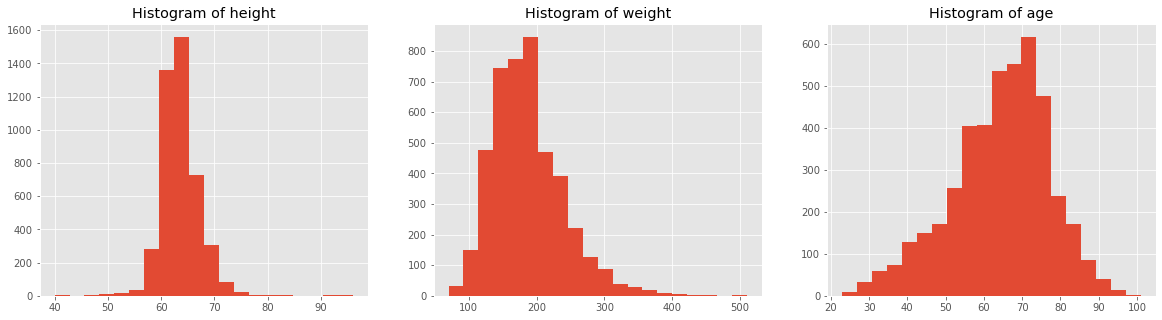

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

numerical_features = ['height', 'weight', 'age']

i = 0
for i in range(3):
    numerical_data[numerical_features[i]] =  numerical_data[numerical_features[i]].astype(int)
    ax[i].hist(numerical_data[numerical_features[i]].values,bins=20)
    ax[i].set_title(f'Histogram of {numerical_features[i]}')
    i+=1

In [127]:
height_mean = np.mean(numerical_data['height'])
weight_mean = np.mean(numerical_data['weight'])
age_mean = np.mean(numerical_data['age'])
height_std = np.std(numerical_data['height'])
weight_std = np.std(numerical_data['weight'])
age_std = np.std(numerical_data['age'])

In [128]:
def random_var_generator(mean, std, col, df):
    for i in range(len(df)):
        if pd.isnull(df.loc[i,col]):
            df.loc[i,col] = np.random.normal(mean, std)
    return df

latest_records = random_var_generator(height_mean, height_std, 'height', latest_records)
latest_records = random_var_generator(weight_mean, weight_std, 'weight', latest_records)
latest_records = random_var_generator(age_mean, age_std, 'age', latest_records)

In [129]:
latest_records['height'] = latest_records['height'].astype(int)
latest_records['weight'] = latest_records['weight'].astype(int)

In [130]:
latest_records = latest_records[(latest_records['height'] > 24) & 
                                (latest_records['weight'] > 50) & 
                                (latest_records['weight'] < 800)]

In [131]:
latest_records.reset_index(drop=True, inplace=True)

#### Transform Categorical Features

In [132]:
categorical_data = data[data.columns[~data.columns.isin(numerical_features)]]
categorical_data = categorical_data[categorical_data.columns[~categorical_data.columns.isin(['q29_annual_scrn'])]]
categorical_data.columns

Index(['member_id', 'comp_form', 'gender', 'race', 'hispanic_latio',
       'language', 'vision_imp', 'hearing_imp', 'q1_pregnant',
       'q2_bcs_past_year', 'q3_ccs_past_year', 'q4_rate_health', 'q8_beliefs',
       'q10_food_insc', 'q11_fruit_veg', 'q12_exercise', 'q13_stress',
       'q14_anxious', 'q15_bh_total_score', 'q16_therapy', 'q17_sleep',
       'q18_substances', 'q19_support', 'q20_meds_np', 'q21_meds_np_prov',
       'q22_meds_diff', 'q23_dme', 'q24_seatbelts', 'q25_living_sit',
       'q26_primary_care', 'q27_last_appt', 'q28_health_lit',
       'q31_treat_changes', 'q32_pain_scale', 'q33_programs_avail'],
      dtype='object')

In [133]:
cats = defaultdict(list)
props = defaultdict(list)

for column in categorical_data.columns:
    data = categorical_data.groupby(column).size().reset_index(name='count')
    for i in range(len(data)):
        cats[column].append(data.loc[i,column])
        props[column].append(data.loc[i, 'count']/sum(data['count']))
        
cats['gender']

[1.0, 2.0]

In [134]:
props['gender']

[0.03177822853279243, 0.9682217714672076]

In [135]:
def random_cat_generator(df, props_dict, cats_dict):
    for key in cats_dict.keys():
        props = props_dict[key]
        cats = cats_dict[key]
        for i in range(len(df)):
            if pd.isnull(df.loc[i, key]):
                df.loc[i, key] = random.choices(cats, weights=props, k=1)
    return df

In [136]:
latest_records = random_cat_generator(latest_records, props, cats)
latest_records.isnull().sum()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


member_id                0
comp_form                0
gender                   0
race                     0
hispanic_latio           0
language                 0
height                   0
weight                   0
vision_imp               0
hearing_imp              0
q1_pregnant              0
q2_bcs_past_year         0
q3_ccs_past_year         0
q4_rate_health           0
q8_beliefs               0
q10_food_insc            0
q11_fruit_veg            0
q12_exercise             0
q13_stress               0
q14_anxious              0
q15_bh_total_score       0
q16_therapy              0
q17_sleep                0
q18_substances           0
q19_support              0
q20_meds_np              0
q21_meds_np_prov         0
q22_meds_diff            0
q23_dme                  0
q24_seatbelts            0
q25_living_sit           0
q26_primary_care         0
q27_last_appt            0
q28_health_lit           0
q29_annual_scrn       3888
q31_treat_changes        0
q32_pain_scale           0
q

In [137]:
latest_records.dropna(inplace=True)
latest_records.reset_index(drop=True)
latest_records.isnull().sum()

<ipython-input-137-d1173fadc6de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_records.dropna(inplace=True)


member_id             0
comp_form             0
gender                0
race                  0
hispanic_latio        0
language              0
height                0
weight                0
vision_imp            0
hearing_imp           0
q1_pregnant           0
q2_bcs_past_year      0
q3_ccs_past_year      0
q4_rate_health        0
q8_beliefs            0
q10_food_insc         0
q11_fruit_veg         0
q12_exercise          0
q13_stress            0
q14_anxious           0
q15_bh_total_score    0
q16_therapy           0
q17_sleep             0
q18_substances        0
q19_support           0
q20_meds_np           0
q21_meds_np_prov      0
q22_meds_diff         0
q23_dme               0
q24_seatbelts         0
q25_living_sit        0
q26_primary_care      0
q27_last_appt         0
q28_health_lit        0
q29_annual_scrn       0
q31_treat_changes     0
q32_pain_scale        0
q33_programs_avail    0
age                   0
dtype: int64

## EDA

In [138]:
targeted_members = pd.merge(members, latest_records, how='inner', on='member_id')
targeted_members.head()

,member_id,comp_form,gender,race,hispanic_latio,language,height,weight,vision_imp,hearing_imp,...,q24_seatbelts,q25_living_sit,q26_primary_care,q27_last_appt,q28_health_lit,q29_annual_scrn,q31_treat_changes,q32_pain_scale,q33_programs_avail,age
0,87518,4.0,2.0,1.0,1.0,1.0,63,180,1.0,1.0,...,1.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,70
1,16498,1.0,2.0,2.0,1.0,1.0,68,249,1.0,1.0,...,1.0,0.0,2.0,2.0,1.0,2.0,2.0,1.0,0.0,79
2,16500,4.0,1.0,7.0,2.0,1.0,67,120,1.0,1.0,...,1.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,46
3,16381,4.0,2.0,1.0,1.0,1.0,76,246,1.0,1.0,...,0.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,77
4,16383,1.0,2.0,2.0,1.0,1.0,67,196,1.0,1.0,...,1.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,62


In [139]:
targeted_members['q29_annual_scrn'].value_counts()

2.0    17968
1.0     5098
Name: q29_annual_scrn, dtype: int64

In [140]:
len(targeted_members['q29_annual_scrn'])

23066

In [141]:
screening_rate = len(targeted_members[targeted_members['q29_annual_scrn'] == 2.0])/len(targeted_members['q29_annual_scrn'])
print(f'The annual screening completion rate is {screening_rate}')

The annual screening completion rate is 0.7789820515043787


In [142]:
latest_records.drop('member_id', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Determine Important Featues for Modeling

#### Reorder Ordinal Categories

In [143]:
one_hot_cats = []
ordinal_cats = ['q4_rate_health', 'q10_food_insc', 'q12_exercise', 'q13_stress', 'q14_anxious', 'q15_bh_total_score',
               'q27_last_appt']

for key in cats.keys():
    if len(cats[key]) > 2 and key not in ordinal_cats:
        one_hot_cats.append(key)
        
one_hot_cats

['member_id',
 'comp_form',
 'race',
 'language',
 'q11_fruit_veg',
 'q17_sleep',
 'q18_substances',
 'q21_meds_np_prov',
 'q23_dme']

In [144]:
for item in ordinal_cats:
    print(f'{item}: {cats[item]}')

q4_rate_health: [1.0, 2.0, 3.0, 4.0, 5.0]
q10_food_insc: [1.0, 2.0, 3.0]
q12_exercise: [1.0, 2.0, 3.0, 4.0, 5.0]
q13_stress: [1.0, 2.0, 3.0]
q14_anxious: [1.0, 2.0, 3.0, 4.0]
q15_bh_total_score: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0]
q27_last_appt: [1.0, 2.0, 3.0]


In [145]:
df = latest_records.copy()
df['q4_rate_health'] = df['q4_rate_health'].map({1.0: 5.0, 2.0: 4.0, 3.0: 2.0, 4.0: 1.0, 5.0: 0.0})
df['q10_food_insc'] = df['q10_food_insc'].map({1.0: 3.0, 2.0:2.0, 3.0: 1.0})
df['q12_exercise'] = df['q12_exercise'].map({5.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0: 4.0})
df['q13_stress'] = df['q13_stress'].map({1.0: 3.0, 2.0: 2.0, 3.0: 1.0})
df['q14_anxious'] = df['q14_anxious'].map({1.0: 4.0, 2.0: 3.0, 3.0: 2.0, 4.0: 1.0})

In [146]:
df.isnull().sum()

comp_form             0
gender                0
race                  0
hispanic_latio        0
language              0
height                0
weight                0
vision_imp            0
hearing_imp           0
q1_pregnant           0
q2_bcs_past_year      0
q3_ccs_past_year      0
q4_rate_health        0
q8_beliefs            0
q10_food_insc         0
q11_fruit_veg         0
q12_exercise          0
q13_stress            0
q14_anxious           0
q15_bh_total_score    0
q16_therapy           0
q17_sleep             0
q18_substances        0
q19_support           0
q20_meds_np           0
q21_meds_np_prov      0
q22_meds_diff         0
q23_dme               0
q24_seatbelts         0
q25_living_sit        0
q26_primary_care      0
q27_last_appt         0
q28_health_lit        0
q29_annual_scrn       0
q31_treat_changes     0
q32_pain_scale        0
q33_programs_avail    0
age                   0
dtype: int64

#### Create Preliminary Train/Test Data, Apply Scaling to Numerical Features, & Apply Class Balancing

In [147]:
X = df.copy(deep=True)
Y = X.copy(deep=True)
Y = Y['q29_annual_scrn']
Y = Y.map({1:1, 2:0})
X.drop('q29_annual_scrn', axis=1, inplace=True)

train, test, train_labels, test_labels = train_test_split(X, Y, test_size=0.25, random_state=5)

In [148]:
scaler = MinMaxScaler()

minority = SMOTE('minority',random_state=4)

train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

train_new, train_labels_new = minority.fit_resample(train, train_labels)

/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:635: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "
<ipython-input-148-ec35f4a5346c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[numerical_features] = scaler.fit_transform(train[numerical_features])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [149]:
importances = mutual_info_classif(train_new, train_labels_new)
feature_importances = pd.DataFrame(importances, X.columns, columns=['importance'])

In [150]:
feature_importances.sort_values(by='importance', ascending=False)

,importance
age,0.337794
weight,0.320323
height,0.313264
q15_bh_total_score,0.140775
q12_exercise,0.129348
q13_stress,0.116785
q11_fruit_veg,0.115656
q14_anxious,0.113522
q4_rate_health,0.111717
q2_bcs_past_year,0.108925


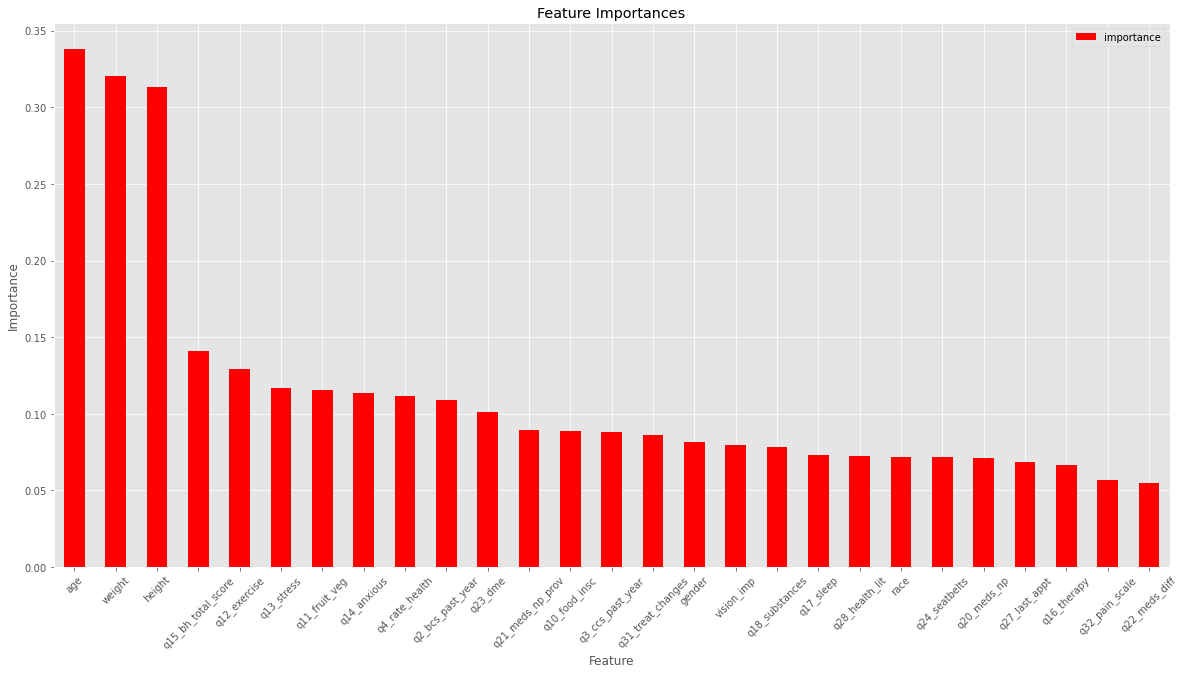

In [151]:
top_importances = feature_importances[feature_importances['importance'] > 0.05].sort_values(by='importance', ascending=False)
top_importances.plot(kind='bar', color='red')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [152]:
lr = LogisticRegression(C=0.001, penalty='l1', solver='liblinear', random_state=7)
model = SelectFromModel(lr)
model.fit(train_new, train_labels_new)
selected_features = X.columns[(model.get_support())]
selected_features

Index(['comp_form', 'q11_fruit_veg', 'q15_bh_total_score', 'q27_last_appt'], dtype='object')

In [153]:
rf = RandomForestClassifier(random_state=5)
rf.fit(train_new, train_labels_new)
rf_importances = rf.feature_importances_

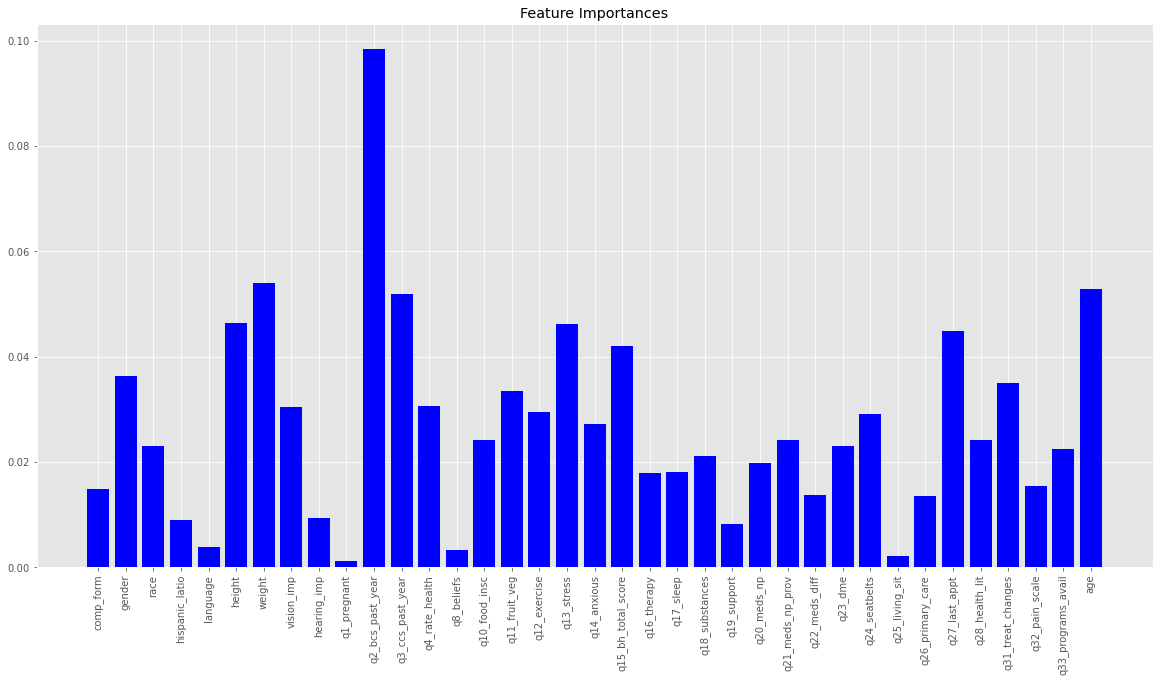

In [154]:
df_features = list(X.columns)
rf_df = pd.DataFrame({'features': df_features, 'importances': rf_importances})
plt.bar(rf_df['features'], rf_df['importances'], color = 'blue')
plt.title('Feature Importances')
plt.xticks(rotation = 90)
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [155]:
rf_df_top_features = rf_df[rf_df['importances'] > 0.04]
rf_df_top_features_list = list(rf_df_top_features['features'])
rf_df_top_features_list

['height',
 'weight',
 'q2_bcs_past_year',
 'q3_ccs_past_year',
 'q13_stress',
 'q15_bh_total_score',
 'q27_last_appt',
 'age']

In [156]:
top_10_importances = feature_importances[feature_importances['importance'] >= 0.10].sort_values(by='importance', ascending=False)
top_10_features = list(top_10_importances.index.values)
top_10_features

['age',
 'weight',
 'height',
 'q15_bh_total_score',
 'q12_exercise',
 'q13_stress',
 'q11_fruit_veg',
 'q14_anxious',
 'q4_rate_health',
 'q2_bcs_past_year',
 'q23_dme']

In [157]:
feature_set = set(top_10_features + rf_df_top_features_list + list(selected_features))
feature_set

{'age',
 'comp_form',
 'height',
 'q11_fruit_veg',
 'q12_exercise',
 'q13_stress',
 'q14_anxious',
 'q15_bh_total_score',
 'q23_dme',
 'q27_last_appt',
 'q2_bcs_past_year',
 'q3_ccs_past_year',
 'q4_rate_health',
 'weight'}

In [158]:
top_features = list(feature_set)
top_features

['q11_fruit_veg',
 'age',
 'q14_anxious',
 'q15_bh_total_score',
 'q27_last_appt',
 'q2_bcs_past_year',
 'q13_stress',
 'weight',
 'q23_dme',
 'q3_ccs_past_year',
 'comp_form',
 'q4_rate_health',
 'q12_exercise',
 'height']

In [159]:
top_features.append('q29_annual_scrn')
df_final = df[top_features]
df_final.shape

(23079, 15)

## Modeling: One-hot Encode Non-Ordinal & Non-Binary Variables, Create New Train/Test Data, Scale Data, Apply Class Balancing, Fit Models Using Hyperparameter Tuning, and Evaluate Models

### One-Hot Encode Categorical Variables That are Not Ordinal or Binary

In [160]:
one_hot_cats

['member_id',
 'comp_form',
 'race',
 'language',
 'q11_fruit_veg',
 'q17_sleep',
 'q18_substances',
 'q21_meds_np_prov',
 'q23_dme']

In [161]:
one_hot_cats_filtered = [cat for cat in one_hot_cats if cat in top_features]
one_hot_cats_filtered

['comp_form', 'q11_fruit_veg', 'q23_dme']

In [162]:
df_final = pd.get_dummies(df_final, columns=one_hot_cats_filtered)
len(df_final.columns)

25

In [163]:
df_final.head()

,age,q14_anxious,q15_bh_total_score,q27_last_appt,q2_bcs_past_year,q13_stress,weight,q3_ccs_past_year,q4_rate_health,q12_exercise,...,comp_form_4.0,q11_fruit_veg_1.0,q11_fruit_veg_2.0,q11_fruit_veg_3.0,q11_fruit_veg_4.0,q11_fruit_veg_5.0,q23_dme_0.0,q23_dme_1.0,q23_dme_2.0,q23_dme_3.0
0,67,1.0,1.0,1.0,1.0,3.0,335,2.0,1.0,1.0,...,0,0,1,0,0,0,0,0,1,0
1,74,1.0,0.0,2.0,1.0,1.0,180,1.0,2.0,1.0,...,1,0,0,0,0,1,0,1,0,0
2,88,1.0,1.0,1.0,2.0,2.0,175,1.0,2.0,2.0,...,1,0,0,0,0,1,1,0,0,0
3,66,2.0,3.0,1.0,2.0,2.0,166,1.0,1.0,0.0,...,0,0,0,0,0,1,0,1,0,0
5,84,1.0,0.0,1.0,2.0,1.0,265,2.0,2.0,2.0,...,0,0,0,0,0,1,1,0,0,0


In [164]:
X = df_final.copy(deep=True)
Y = df_final.copy(deep=True)
Y = Y['q29_annual_scrn']
Y = Y.map({1:1, 2:0})
X.drop('q29_annual_scrn', axis=1, inplace=True)

train, test, train_labels, test_labels = train_test_split(X, Y, test_size=0.25, random_state=5)


In [165]:
# Create Training and Testing Data Based on Optimal Scaling and Sampling Method Combination

smote = SMOTE(random_state=4)
majority = RandomUnderSampler('majority',random_state=4)
minority = SMOTE('minority',random_state=4)

min_max = MinMaxScaler()
standard = StandardScaler()

sampling_methods = [smote, majority, minority]
scaling_methods = [min_max, standard]

training_testing_dict = defaultdict(tuple)

train_new = train.copy(deep=True)
test_new = test.copy(deep=True)

i = 0
for scaling_method in scaling_methods:
    for sampling_method in sampling_methods:
        train_new[numerical_features] = scaling_method.fit_transform(train[numerical_features])
        test_new[numerical_features] = scaling_method.transform(test[numerical_features])
        train_new, train_labels_new = sampling_method.fit_resample(train_new, 
                                                                   train_labels)
        training_testing_dict[i] = train_new, test_new, train_labels_new, test_labels
        
        train_new = train.copy(deep=True)
        test_new = test.copy(deep=True)
        train_labels_new = train_labels.copy(deep=True)
        
        i+= 1

/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "
/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py:635: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [166]:
# Function to Find Optimal Training Data

def optimize_data(train_test_data, model):
    
    i = 0
    index = None
    best_loss = 1000
    model_new = model
    
    for train, test, train_labels, test_labels in train_test_data.values():
        model_new.fit(train, train_labels)
        probs = model_new.predict_proba(test)
        loss = log_loss(test_labels, probs)

        if loss < best_loss:
            best_loss = loss
            index = i
        i += 1
        model_new = model
            
    return train_test_data[index]

In [167]:
# Using Arbitrary XGB Classifier Model to Find Optimal Class Balanced Training Data

arbitrary_model = XGBClassifier(random_state=5)

train, test, train_labels, test_labels = optimize_data(training_testing_dict, 
                                                       arbitrary_model)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [168]:
# scaler = MinMaxScaler()

# minority = SMOTE('minority',random_state=4)

# train[numerical_features] = scaler.fit_transform(train[numerical_features])
# test[numerical_features] = scaler.transform(test[numerical_features])

# train_new, train_labels_new = minority.fit_resample(train, train_labels)

In [169]:
# model for optimizing hyperparameters

def optimize_params(train, train_labels, rs):
    
    rs.fit(train, train_labels)
    model = rs.best_estimator_
    
    return model

In [170]:
# Baseline Model

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train, train_labels)

DummyClassifier(strategy='most_frequent')

In [171]:
# 1. Random Forest Model

param_grid = {
    'n_estimators': np.arange(100,350,50).astype(int),
    'max_features': ['sqrt'] + list(np.arange(0.3,1,0.1)),
    'min_samples_leaf': [5,10,15],
    'min_samples_split': [5,10,15],
    'bootstrap': [True,False],
    'criterion': ['gini', 'entropy']
}

rf_estimator = RandomForestClassifier(random_state=4)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=4)

rf = RandomizedSearchCV(rf_estimator, param_grid, n_jobs=-1, cv=cv, verbose = 3, 
                        n_iter=10, scoring='neg_log_loss', random_state=4)

best_rf = optimize_params(train, train_labels, rf)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


In [172]:
# 2. Logistic Regression Model

# Create Instance of Model
logreg = LogisticRegression(random_state = 4)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = [0.001, 0.01, 0.1, 1, 10]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=4)

rs_logreg = RandomizedSearchCV(logreg, space, n_iter=10, scoring='neg_log_loss', 
                            n_jobs=-1, cv=cv, random_state=4)

best_log = optimize_params(train, train_labels, rs_logreg)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [173]:
# 3. Extreme Gradient Boosted Machine Model

xgb = XGBClassifier(random_state=4)

param_grid2 = {
    'n_estimators': np.arange(20,200,50).astype(int),
    'learning_rate': [0.001, 0.01, 0.1],
    'colsample_bytree' : [0.3, 0.5, 0.7],
    'lambda': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.75, 1.0],
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=4)

rs_xgb = RandomizedSearchCV(xgb, param_grid2, cv=cv, n_iter=10, random_state=5, 
                            scoring='neg_log_loss', n_jobs=-1)

best_xgb = optimize_params(train, train_labels, rs_xgb)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [174]:
# 4. Light Gradient Boosted Machine Model

lgbm = LGBMClassifier(random_state=4)

param_grid3 = {'n_estimators': np.arange(20,200,50).astype(int),
              'learning_rate': [0.001, 0.01, 0.1],
               'colsample_bytree' : [0.5, 0.7, 0.9],
               'subsample':[0.5, 0.7, 0.9],
               'lambda_l2': [0.001, 0.01, 0.1]
              }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=4)

rs_lgbm = RandomizedSearchCV(lgbm, param_grid3, cv=cv, n_iter=10,random_state=5, 
                            verbose=3,scoring='neg_log_loss', n_jobs=-1)
            
best_lgbm = optimize_params(train, train_labels, rs_lgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.9s finished


[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001


## Model Evaluation & Metrics

In [175]:
# Create Predictions and Evaluate Models on Test Data

model_types = ['Dummy','Random Forest', 'Logistic Regression', 'Extreme Gradient Boosted Machine',
              'Light Gradient Boosted Machine']

models = [dummy, best_rf, best_log, best_xgb, best_lgbm]
model_metrics = defaultdict(list)

for model, model_type in zip(models, model_types):
    preds = model.predict(test)
    probs = model.predict_proba(test)
    acc = accuracy_score(test_labels, preds)
    recall = recall_score(test_labels, preds, average='binary')
    prec = precision_score(test_labels, preds, average='binary')
    f1 = f1_score(test_labels, preds)
    auc = roc_auc_score(test_labels, probs[:,1])
    loss = log_loss(test_labels, probs)
    metrics = [acc, prec, recall, f1, auc, loss]
    model_metrics[model_type] = metrics

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [176]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.index = ['Accuracy', 'Precision', 'Recall', 'F1 Score',
                         'ROC AUC', 'Log Loss']
model_metrics_df

,Dummy,Random Forest,Logistic Regression,Extreme Gradient Boosted Machine,Light Gradient Boosted Machine
Accuracy,0.774350,0.762565,0.717331,0.759445,0.770017
Precision,0.000000,0.449102,0.388475,0.450231,0.482711
Recall,0.000000,0.230415,0.440092,0.298771,0.268049
F1 Score,0.000000,0.304569,0.412676,0.359187,0.344691
ROC AUC,0.500000,0.670399,0.676908,0.681124,0.687023
Log Loss,7.793672,0.514839,0.575393,0.553439,0.532535


## Visualization of Model Performance

In [177]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig = plt.gcf()
    fig.set_size_inches(7,7)
    plt.show()

In [178]:
def getImportances(feature_importances):
    top_importances = []
    top_features_list = []

    for x,y in feature_importances:
        if(y > 0.025):
            top_features_list.append(x)
            top_importances.append(y)
    return top_features_list, top_importances

In [179]:
def plotImportances(top_importances, top_features_list, model_type, color):
    x_values = list(range(len(top_importances)))
    plt.bar(x_values, top_importances, orientation= 'vertical', color=color)
    plt.xticks(x_values, top_features_list, rotation = 'vertical')
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Top Variable Importances: {0}'.format(model_type))
    fig = plt.gcf()
    fig.set_size_inches(7,7)
    plt.show()

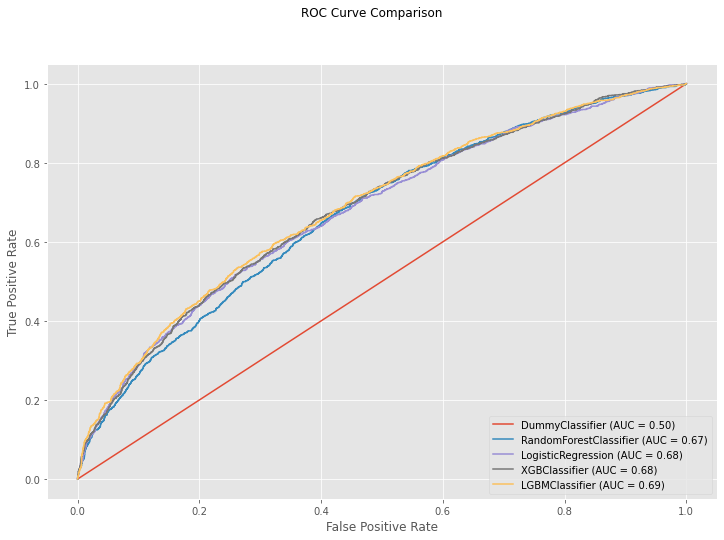

In [180]:
# ROC AUC

i = 0

for model, model_type in zip(models, model_types):
    if i == 0:
        disp = plot_roc_curve(model, test, test_labels)
        axis = disp.ax_
    else:
        new_disp = plot_roc_curve(model, test, test_labels, ax=axis)
    i+=1
    
new_disp.figure_.suptitle("ROC Curve Comparison")
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

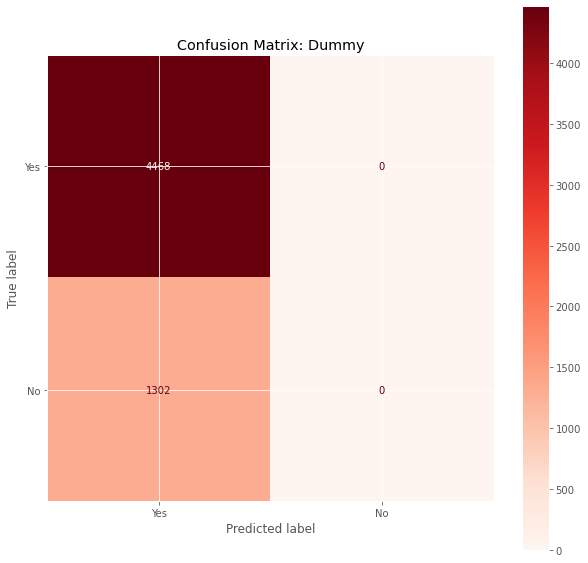

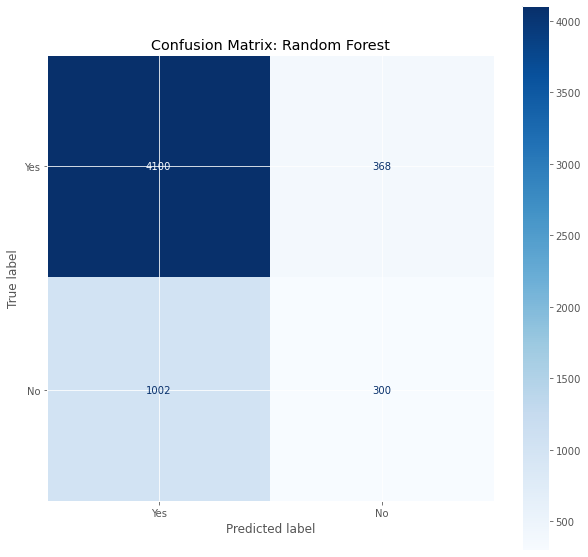

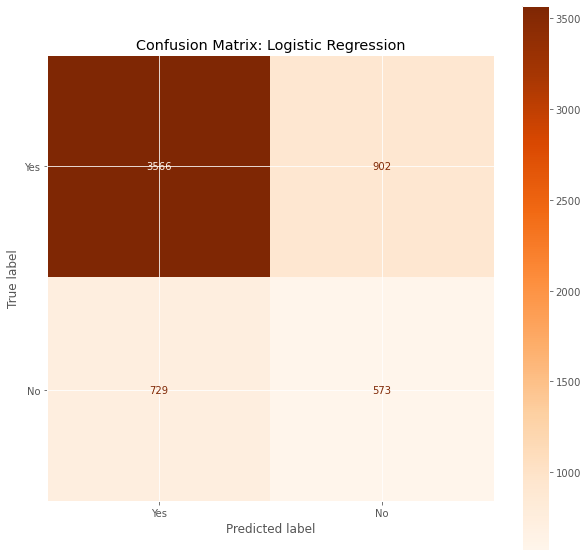

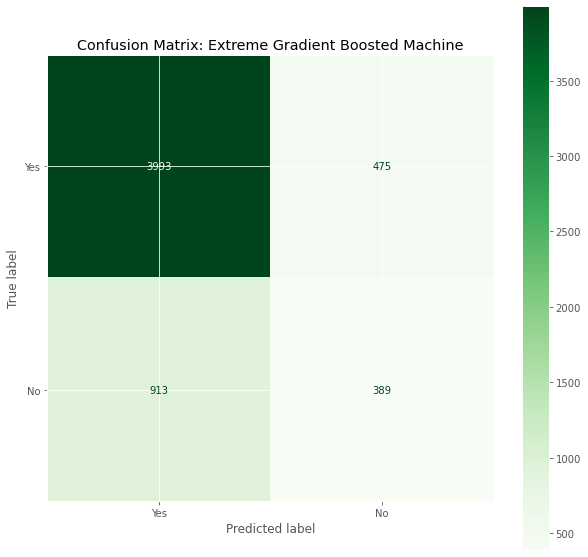

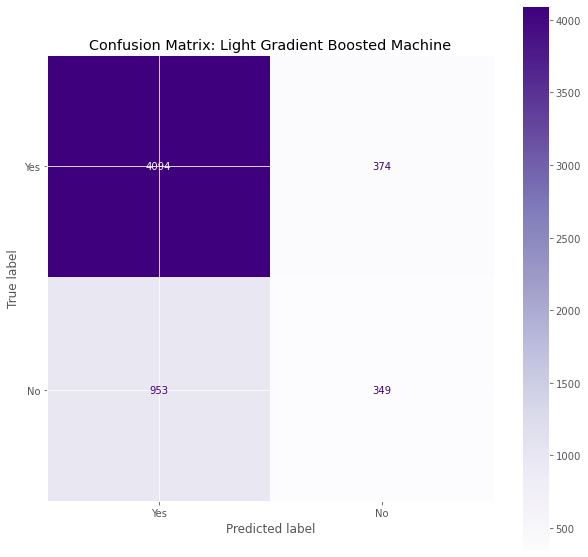

In [181]:
# Confusion Matrices

classes = ['Yes', 'No']

cmaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens, plt.cm.Purples]

for model, model_type, cmap in zip(models, model_types, cmaps):
    plot_cm(model, test, test_labels, display_labels=classes, 
            cmap=cmap)
    plt.title(f'Confusion Matrix: {model_type}')
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    plt.show()

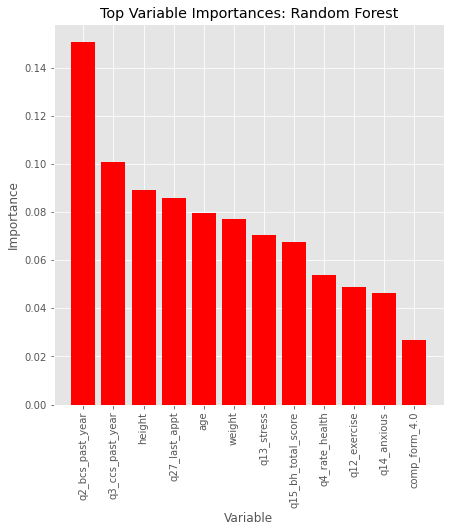

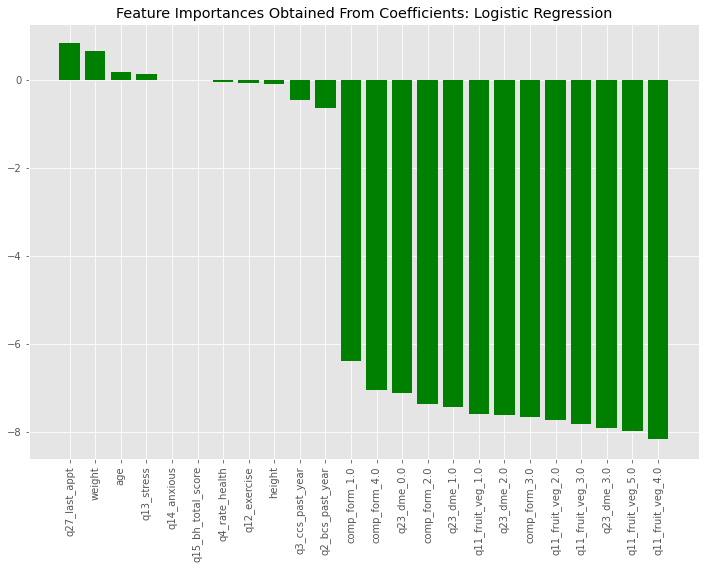

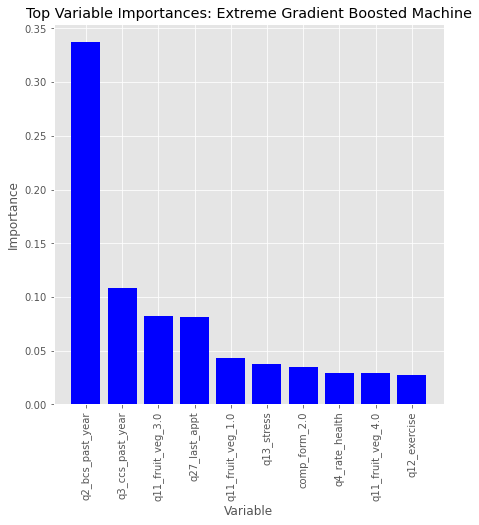

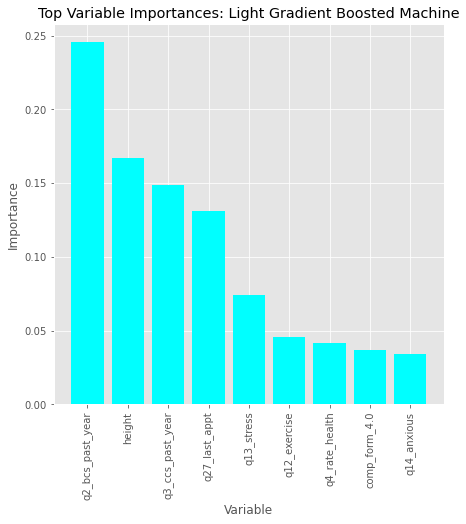

In [182]:
# Feature Importances

xgb_rf = ['Random Forest', 'Extreme Gradient Boosted Machine']
colors=['black', 'red', 'green', 'blue', 'cyan']

for model, model_type, color in zip(models, model_types, colors):
    if model_type == 'Light Gradient Boosted Machine':
        lgbm_importances = model.booster_.feature_importance(importance_type='gain')/sum(model.booster_.feature_importance(importance_type='gain'))
        importances = list(lgbm_importances)
        feature_list = list(X.columns)
        feature_importances = [(feature, importance) for feature, importance in 
                               zip(feature_list,importances)]
        feature_importances_ = sorted(feature_importances, key = lambda x: x[1], reverse=True)
        top_features_list, top_importances = getImportances(feature_importances_)
        plotImportances(top_importances, top_features_list, model_type, color)

    elif model_type in xgb_rf:
        importances = list(model.feature_importances_)
        feature_list = list(X.columns)
        feature_importances = [(feature, importance) for feature, importance in 
                               zip(feature_list,importances)]
        feature_importances_ = sorted(feature_importances, key = lambda x: x[1], reverse=True)
        top_features_list, top_importances = getImportances(feature_importances_)
        plotImportances(top_importances, top_features_list, model_type, color)
        
    elif model_type == 'Logistic Regression':
        importances = pd.DataFrame(data={'Attribute': X.columns,
                                         'Importance': model.coef_[0]})
        importances = importances.sort_values(by='Importance', ascending=False)
        plt.bar(x=importances['Attribute'], height=importances['Importance'], color=color)
        plt.title('Feature Importances Obtained From Coefficients: Logistic Regression')
        fig=plt.gcf()
        fig.set_size_inches(12,8)
        plt.xticks(rotation='vertical')
        plt.show()
    
    else:
        continue
        
        